# GEODOS data processing

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime #, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [68]:
directory = '/storage/stations/Polednik/geodos/2021/10/10'
#directory = '/storage/stations/Polednik/geodos/2021/10/13'
#directory = '/storage/stations/Polednik/geodos/2021/10/EC'

fto = directory + '/DATALOG.TXT'

l=[]
l.extend(range(0,500))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
#df.drop(df[df[0]=='$GPGSV'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS',3]
fw = df.loc[df[0]=='$AIRDOS',2]
last = df.loc[df[0]=='$AIRDOS'].index
print ('s.n.: ',sn[0])
print ('f.v.: ',fw[0])
print(df.loc[df[0]=='$AIRDOS',1])
print(len(df))
print(last[-1:][0])

#!!!
#df.drop(df.index[:last[-1:][0]], inplace=True) # keep only last run

s.n.:  1290c00806a20091e412a000a0000010
f.v.:  51832f3
0         GEO2
68310     GEO2
68311     GEO2
68312     GEO2
68313     GEO2
          ... 
209368    GEO2
209369    GEO2
209370    GEO2
209371    GEO2
209372    GEO2
Name: 1, Length: 141064, dtype: object
209373
209372


## Fill position and time by GPS NMEA records

In [69]:
#df.drop(df.loc[(df[0]=='$GNRMC') & (df[2]=='V')].index, inplace=True)
df.loc[(df[0]=='$GNRMC'),'flag']=True
df.loc[(df[0]=='$HIST'),'flag']=False
df.flag = df.flag.fillna(method='ffill')
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',5])
#df.loc[(df[0]=='$TIME') & (df['flag']),'on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
#df['on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
df['on_miliseconds'] = pd.to_numeric(df.loc[(df[0]=='$TIME') & (df['flag']),1]) * 1000
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GNRMC',1]
df['gps_date'] = df.loc[df[0]=='$GNRMC',9]
df['alt'] = df.loc[df[0]=='$GNGGA',9]
df.loc[(df[0]=='$GNRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GNRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.index
#df['meas'] = df.loc[df[0]=='$HIST',1]
df.loc[df[0]=='$HITS','meas'] = np.nan
df = df.fillna(method='ffill')
df.meas = df.meas.astype(int)
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GNRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
#df.drop('date', axis=1, inplace=True)
#df.drop('miliseconds', axis=1, inplace=True)
#df.drop('on_miliseconds', axis=1, inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,499,flag,on_miliseconds,miliseconds,alt,lat,lon,date,meas,UTC
1,$GNVTG,GEO2,T,1290c00806a20091e412a000a0000010,M,0.377,N,0.697,K,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1,NaT
2,$GNGGA,143208.00,4903.84979,N,01323.70453,E,1,09,1.01,1351.1,...,NaN,NaN,NaN,NaN,1351.1,NaN,NaN,NaT,2,NaT
3,$GNGSA,A,3,03,04,22,01,17,19,09,...,NaN,NaN,NaN,NaN,1351.1,NaN,NaN,NaT,3,NaT
4,$GNGSA,A,3,03,04,22,01,17,19,09,...,NaN,NaN,NaN,NaN,1351.1,NaN,NaN,NaT,4,NaT
5,$GPGSV,4,1,14,01,42,150,32,03,71,...,NaN,NaN,NaN,NaN,1351.1,NaN,NaN,NaT,5,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68305,$HITS,4,101776,56,118812,9,210650,10,229111,16,...,NaN,False,501129240.0,502052810.0,1351.4,49.064121,13.395117,2021-08-18 09:44:17,68304,2021-08-18 09:59:40.570
68306,$HIST,30808,502068.73,86634.75,6.50,-0.26,-257,-257,-257,55524,...,NaN,False,501129240.0,502068730.0,1351.4,49.064121,13.395117,2021-08-18 09:44:17,68306,2021-08-18 09:59:56.490
68307,$HITS,3,209350,10,258456,27,261942,13,-257,55524,...,NaN,False,501129240.0,502068730.0,1351.4,49.064121,13.395117,2021-08-18 09:44:17,68306,2021-08-18 09:59:56.490
68308,$HIST,30809,502084.67,86647.50,6.50,-0.26,-257,-257,-257,54655,...,NaN,False,501129240.0,502084670.0,1351.4,49.064121,13.395117,2021-08-18 09:44:17,68308,2021-08-18 10:00:12.430


In [70]:
df = df.loc[df['date']>'2021-08-15 15:00:00'].loc[df['date']<'2021-08-15 20:00:00']

In [236]:
df

,0,1,2,3,4,5,6,7,8,9,...,499,flag,on_miliseconds,miliseconds,alt,lat,lon,date,meas,UTC
35924,$HIST,16200,264653.41,86753.75,22.25,4.10,-27,884,884,49037,...,NaN,False,264637590.0,264653410.0,1397.7,49.063852,13.395472,2021-08-15 16:02:40,35924,2021-08-15 16:02:55.820
35925,$HITS,4,18305,53,24290,34,40905,16,230377,11,...,NaN,False,264637590.0,264653410.0,1397.7,49.063852,13.395472,2021-08-15 16:02:40,35924,2021-08-15 16:02:55.820
35926,$HIST,16201,264669.61,86754.25,22.25,4.10,-18,884,884,46404,...,NaN,False,264637590.0,264669610.0,1397.7,49.063852,13.395472,2021-08-15 16:02:40,35926,2021-08-15 16:03:12.020
35927,$HITS,3,100038,10,139741,33,224064,115,884,46404,...,NaN,False,264637590.0,264669610.0,1397.7,49.063852,13.395472,2021-08-15 16:02:40,35926,2021-08-15 16:03:12.020
35928,$HIST,16202,264685.81,86756.25,22.25,4.10,-16,884,884,43717,...,NaN,False,264637590.0,264685810.0,1397.7,49.063852,13.395472,2021-08-15 16:02:40,35928,2021-08-15 16:03:28.220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37859,$GPGSV,4,3,13,20,52,295,47,27,05,...,NaN,False,277954210.0,278929770.0,1350.5,49.063936,13.395348,2021-08-15 19:44:37,37859,2021-08-15 20:00:52.560
37860,$GPGSV,4,4,13,49,33,191,45,27,05,...,NaN,False,277954210.0,278929770.0,1350.5,49.063936,13.395348,2021-08-15 19:44:37,37860,2021-08-15 20:00:52.560
37861,$GLGSV,2,1,07,66,36,137,48,67,87,...,NaN,False,277954210.0,278929770.0,1350.5,49.063936,13.395348,2021-08-15 19:44:37,37861,2021-08-15 20:00:52.560
37862,$GLGSV,2,2,07,77,81,183,29,78,24,...,NaN,False,277954210.0,278929770.0,1350.5,49.063936,13.395348,2021-08-15 19:44:37,37862,2021-08-15 20:00:52.560


## Add individual events to histogram

In [71]:
HISTHITS = 9 # Ratmirov
#HISTHITS = 28 # ABSjets
FIRSTCH = 2

df.dropna(subset=['date'], inplace=True)
hist = df.loc[df[0]=='$HIST'].iloc[:,:9+HISTHITS].copy()
hist.iloc[:,1:] = hist.iloc[:,1:].apply(pd.to_numeric) #,errors='coerce')
#hist[0] = df[0]
hist['alt'] = df['alt'].apply(pd.to_numeric,errors='coerce')
hist['lat'] = df['lat'].apply(pd.to_numeric,errors='coerce')
hist['lon'] = df['lon'].apply(pd.to_numeric,errors='coerce')
hist['meas'] = df['meas'].apply(pd.to_numeric,errors='coerce')
hist['UTC'] = df['UTC']
hist['temperature'] = hist.loc[:,4]
#hist.iloc[:,18:269] = 0
hist.set_index('meas', inplace=True)

hits = df.loc[df[0]=='$HITS'].copy()
#hits['meas'] = hist.index
hits.iloc[:,1:] = hits.iloc[:,1:].apply(pd.to_numeric)
hits['UTC'] = df['UTC']
hits.set_index('meas', inplace=True)


In [220]:
events = pd.DataFrame(columns=['time', 'energy'])


try:
    for i in range(len(hits)):
        for j in range(hits.iloc[i,1]):
            event_ch = hits.iloc[i,j*2+3]
            event_time = hits.iloc[i,j*2+2]
            #etime = hist.iloc[i].UTC - pd.Timedelta(microseconds=64*(65535*4-event_time))
            etime = hits.iloc[i].UTC - pd.Timedelta(microseconds=54*65535*4) + pd.Timedelta(microseconds=53*event_time)
            events = pd.concat([events, pd.DataFrame.from_records([{'time':etime, 'energy':event_ch}])])

except:
    print(i,j)
    raise
            
events.set_index('time', drop=False, inplace=True)
events.sort_index(inplace=True)

In [239]:
hist['temperature'] = hist.loc[:,4]

## Flux

In [224]:
histogram = hist

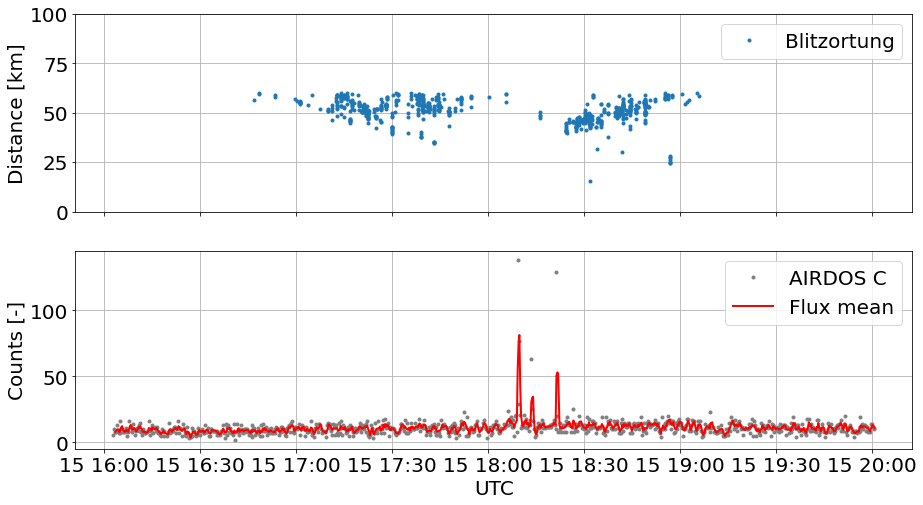

In [231]:
NOISE_LEVEL = 11
LAST_CHANNEL = 18
WINDOW = 3

blitz = pd.read_csv(directory + "/blitz.csv")
blitz['date'] = pd.to_datetime(blitz['date'])
blitz.set_index('date', inplace=True)
blitz.sort_index(inplace=True)
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
blitz = blitz.loc[blitz['date']>'2021-08-15 16:00:00'].loc[blitz['date']<'2021-08-15 23:00:00']

xx = histogram
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-7-25 17:45:00':'2021-7-25 19:00:00']
#blitz = blitz.loc['2021-7-25 18:00:00':'2021-7-25 18:20:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

#xx['flux1'] = (xx.iloc[:,range(NOISE_LEVEL,NOISE_LEVEL+2)].sum(axis=1))
#xx['flux2'] = (xx.iloc[:,range(NOISE_LEVEL+2,NOISE_LEVEL+7)].sum(axis=1))
#xx['flux3'] = (xx.iloc[:,range(NOISE_LEVEL+7,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

fig, (ax6, ax5) = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
matplotlib.rcParams.update({'font.size': 20})

ax5.plot(xx['flux'], c='gray', linestyle='', marker='.', label='AIRDOS C')
#ax5.plot(xx['flux1'], label='flux1')
#ax5.plot(xx['flux2'], label='flux2')
#ax5.plot(xx['flux3'], label='flux3')
ax5.plot(xx['fluxmean'], c='red', lw=2, label='Flux mean')
ax5.set_ylabel('Counts [-]')
ax5.set_xlabel('UTC')
#ax5.set_ylim(0,21)
ax5.legend()
#ax5.set_yscale('log')
ax5.grid()

ax6.plot(blitz.date, blitz.km, ls='', marker='.', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,100)
ax6.grid()
#ax6.vlines(x=gps['timeR'], ymin=0, ymax=130, color='red', label='Trigger STP', lw=1, linestyle='-', alpha=0.3)
ax6.legend()



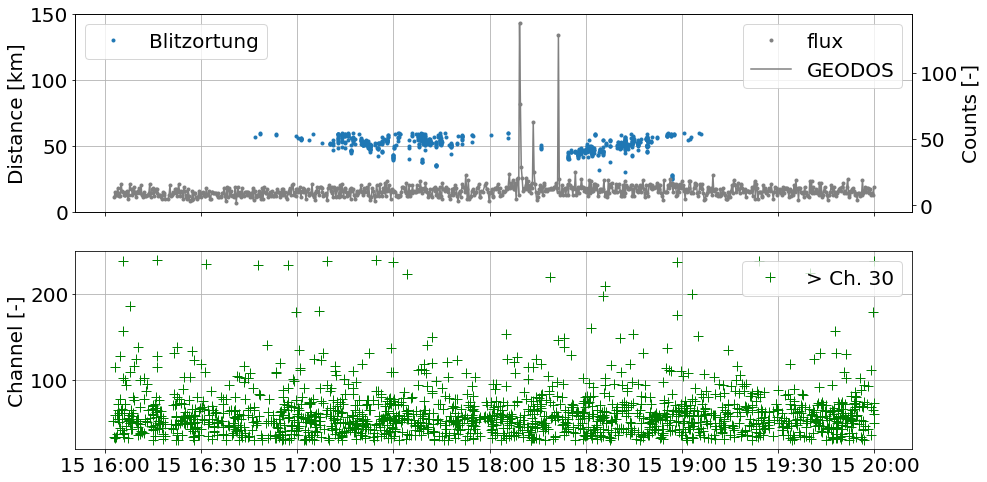

In [232]:
NOISE_LEVEL = 11
LAST_CHANNEL = 18
WINDOW = 20

xx = histogram
xx.set_index('UTC', inplace = True, drop=False)

FROM = '2021-08-15 15:00:00'
TO = '2021-08-15 20:00:00'

xx = xx.loc[FROM:TO].copy()
blitz_x = blitz.loc[FROM:TO].copy()
events_x = events.loc[FROM:TO].copy()

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

#xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

fig, (ax6, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
ax5_twin = ax6.twinx()

ax5_twin.plot(xx['flux'], c='gray', linestyle='', marker='.', label='flux')
ax5_twin.plot(xx['flux'], c='gray', label='GEODOS')
#ax5_twin.plot(xx['fluxmean'], c='gray', label='Geodos avg')
ax5_twin.set_ylabel('Counts [-]')
#ax5.set_ylim(0,21)
ax5_twin.legend()
#ax5.set_yscale('log')
#ax5_twin.grid()
#ax5.set_xlabel('UTC')

ax6.plot(blitz_x.date, blitz_x.km, ls='', marker='.', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,150)
ax6.grid()
#ax6.vlines(x=gps_x['timeR'], ymin=0, ymax=150, color='red', label='Trigger', lw=1, alpha=0.5)
ax6.legend(loc=2)

ax2.plot(events_x.loc[events_x.energy>30].energy, ls='', ms=10, marker='+', color='green', label='> Ch. 30')
ax2.set_ylabel('Channel [-]')
ax2.grid()
#ax2.set_ylim(0,200)
ax2.legend(loc=1)


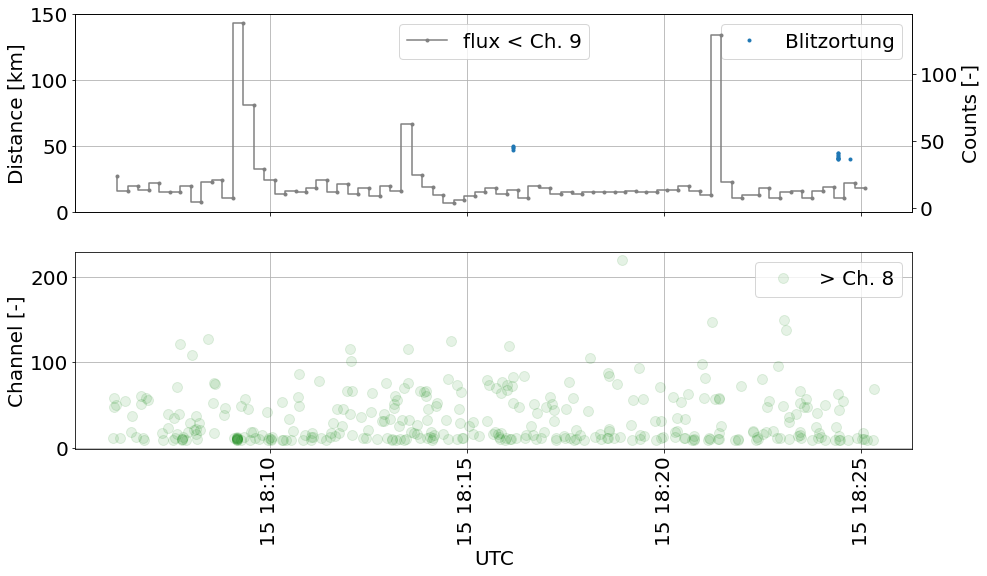

In [233]:
NOISE_LEVEL = 11
LAST_CHANNEL = 18
WINDOW = 20

xx = histogram
xx.set_index('UTC', inplace = True, drop=False)

FROM = '2021-08-15 18:06:00'
TO = '2021-08-15 18:25:20'

xx = xx.loc[FROM:TO].copy()
blitz_x = blitz.loc[FROM:TO].copy()
events_x = events.loc[FROM:TO].copy()

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

#xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

fig, (ax6, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
ax5_twin = ax6.twinx()

ax5_twin.plot(xx['flux'], c='gray', linestyle='-', marker='.', label='flux < Ch. 9', drawstyle='steps-pre')
#ax5_twin.plot(xx['flux'], c='gray', label='GEODOS')
#ax5_twin.plot(xx['fluxmean'], c='gray', label='Geodos avg')
ax5_twin.set_ylabel('Counts [-]')
#ax5.set_ylim(0,21)
ax5_twin.legend()
#ax5.set_yscale('log')
#ax5_twin.grid()
#ax5.set_xlabel('UTC')

ax6.plot(blitz_x.date, blitz_x.km, ls='', marker='.', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,150)
ax6.grid()
#ax6.vlines(x=gps_x['timeR'], ymin=0, ymax=150, color='red', label='Trigger', lw=1, alpha=0.5)
ax6.legend()

#ax2.plot(events_x.loc[events_x.energy>0].energy, ls='', ms=10, marker='+', color='green', label='> Ch. 30')
ax2.plot(events_x.energy, ls='', ms=10, marker='o', color='green', label='> Ch. 8', alpha=0.1)
ax2.set_ylabel('Channel [-]')
ax2.grid()
#ax2.set_ylim(0,200)
ax2.legend(loc=1)
ax2.set_xlabel('UTC')
ax2.tick_params(axis='x', labelrotation = 90)


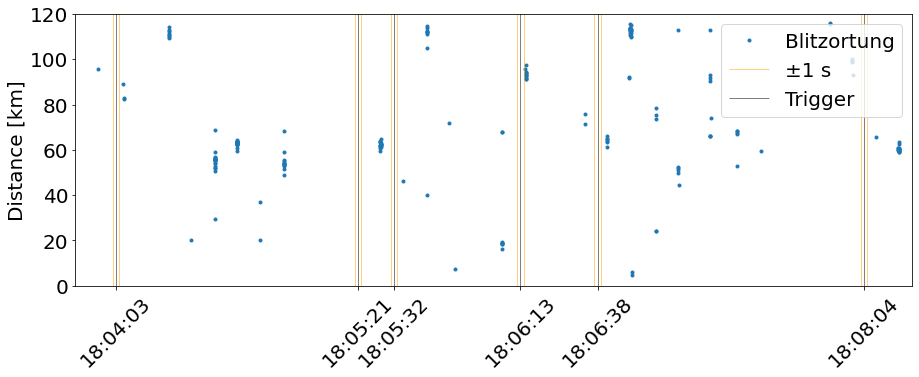

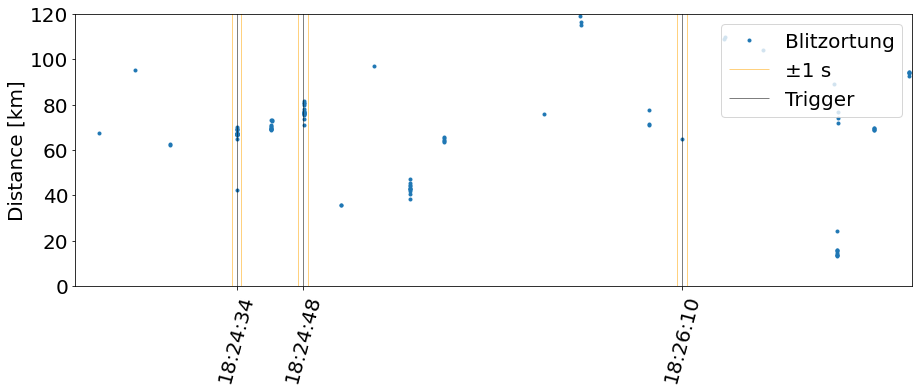

In [6]:
from datetime import datetime, timedelta
gps['timelabel'] = gps['timeR'].dt.strftime('%H:%M:%S')

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 20})

plt.plot(blitz.date, blitz.km, ls='', marker='.', label='Blitzortung')
plt.ylabel('Distance [km]')
#plt.grid()
plt.ylim(0,120)
plt.vlines(x=gps['timeR'] + timedelta(seconds=1), ymin=0, ymax=130, color='orange', label='±1 s', lw=0.5)
plt.vlines(x=gps['timeR'] - timedelta(seconds=1), ymin=0, ymax=130, color='orange',  lw=0.5)
plt.vlines(x=gps['timeR'], ymin=0, ymax=130, color='black', label='Trigger', lw=0.5)
pyplot.xticks(gps['timeR'], gps['timelabel'], rotation='vertical')
plt.xlim(pd.to_datetime('2021-7-25 18:03:50'),pd.to_datetime('2021-7-25 18:08:20'))
plt.xticks(rotation=45)
plt.legend(loc='upper right')

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 20})

plt.plot(blitz.date, blitz.km, ls='', marker='.', label='Blitzortung')
plt.ylabel('Distance [km]')
plt.legend()
#plt.grid()
plt.ylim(0,120)
plt.vlines(x=gps['timeR'] + timedelta(seconds=1), ymin=0, ymax=130, color='orange', label='±1 s', lw=0.5)
plt.vlines(x=gps['timeR'] - timedelta(seconds=1), ymin=0, ymax=130, color='orange',  lw=0.5)
plt.vlines(x=gps['timeR'], ymin=0, ymax=130, color='black', label='Trigger', lw=0.5)
pyplot.xticks(gps['timeR'], gps['timelabel'], rotation='vertical')
#plt.xlim(pd.to_datetime('2021-7-25 18:15:00'),pd.to_datetime('2021-7-25 18:30:00'))
plt.xlim(pd.to_datetime('2021-7-25 18:24:00'),pd.to_datetime('2021-7-25 18:27:00'))
plt.xticks(rotation=75)
plt.legend(loc='upper right')

None

# --------------------------------------------------------------------------------- END

## Plot Flux

/tmp/ipykernel_20863/4079859670.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_20863/4079859670.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


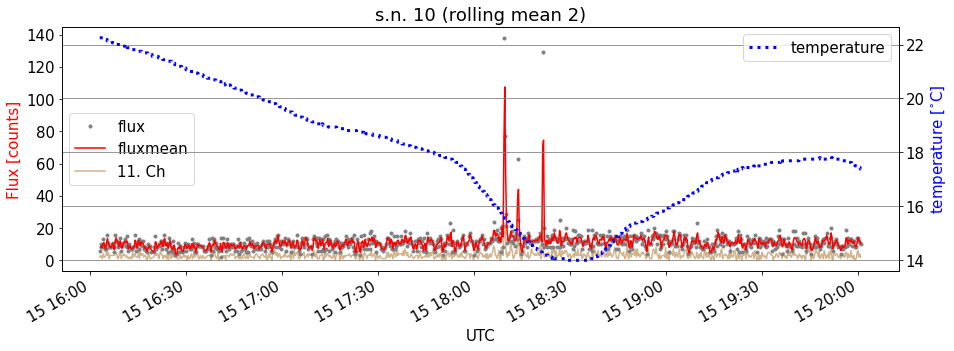

In [243]:
NOISE_LEVEL = 11
LAST_CHANNEL = 18
WINDOW = 2

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

#histogram.read_csv(dto + '/histogram.csv')
xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2021-08-15 17:45:00':'2021-08-15 18:40:00']
#xx = xx.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
#xx = xx.loc['2021-05-12 8:35:00':'2021-05-12 12:45:00']

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=6)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



/tmp/ipykernel_20863/3024544145.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_20863/3024544145.py:33: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


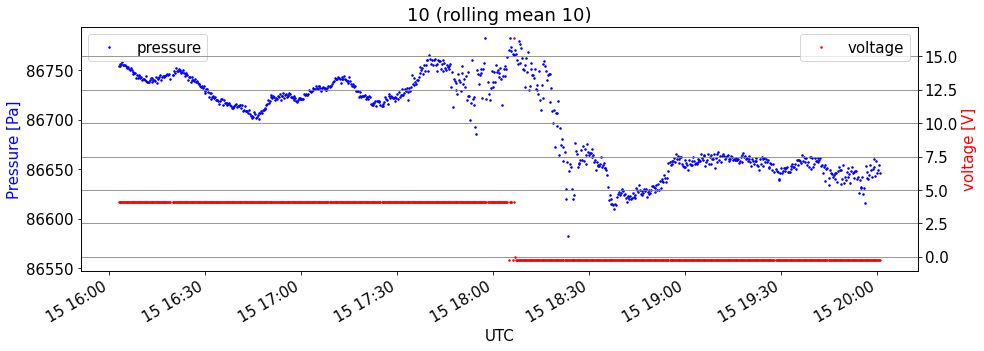

In [244]:
NOISE_LEVEL = 7
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx[3].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx[5].plot(c='red', label='voltage', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('voltage [V]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



/tmp/ipykernel_20863/1760063377.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_20863/1760063377.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


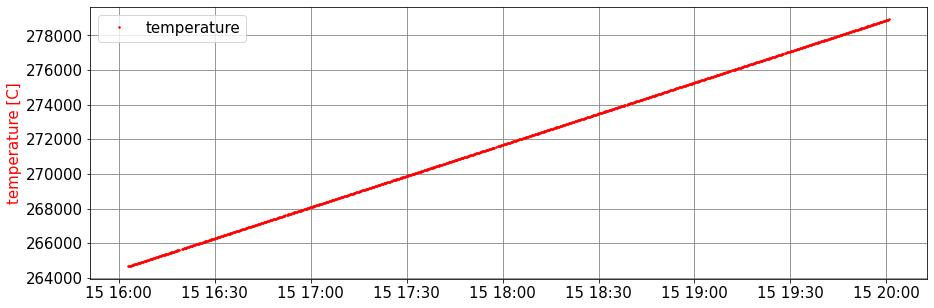

In [245]:
NOISE_LEVEL = 7
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']

#plt.ylim([0,14000])
plt.plot(xx.index, xx[2], c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



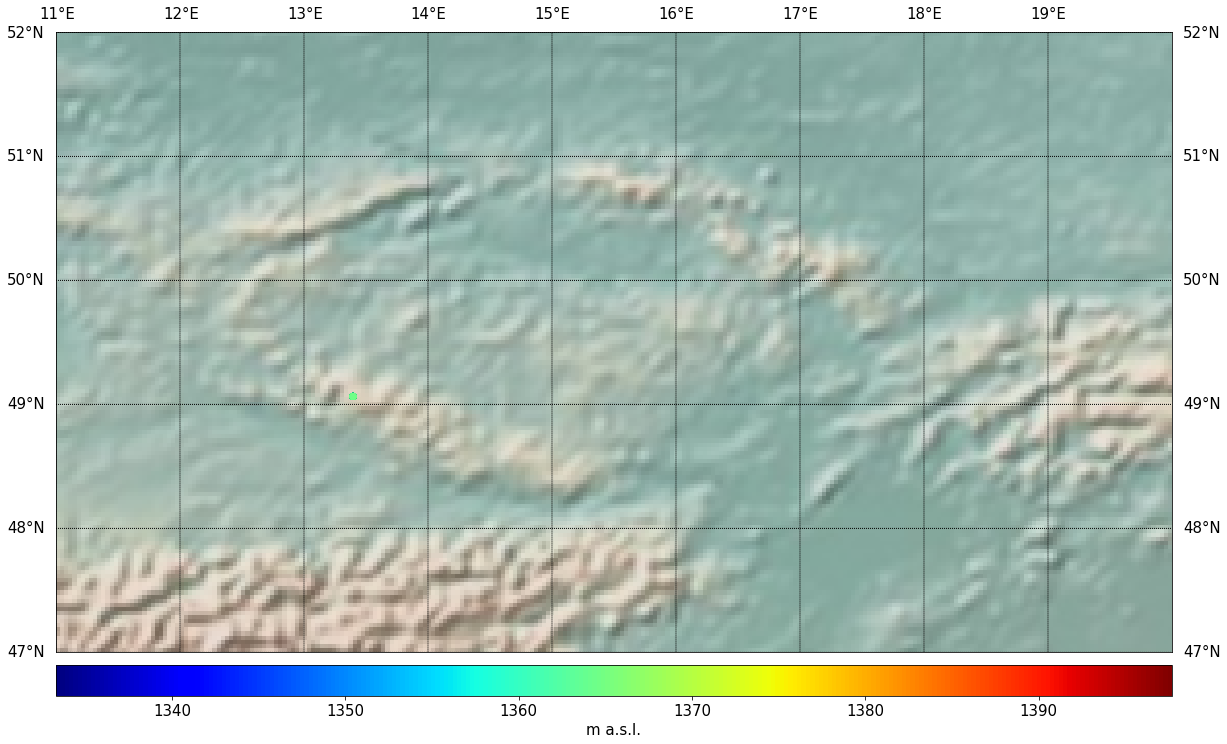

In [247]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import urllib, os

plt.figure(figsize=(20,20))
plt.tight_layout()

matplotlib.rcParams.update({'font.size': 15})

# create Basemap instance.
#m = Basemap(projection='kav7',lon_0=0)
m = Basemap(projection='cyl',lon_0=0, llcrnrlon=11,llcrnrlat=47,urcrnrlon=20,urcrnrlat=52)
#m = Basemap(projection='robin',lon_0=0)
#m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

x, y = m(histogram.lon.tolist(),histogram.lat.tolist())
#m.drawmapboundary(fill_color='#99ffff')
#m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
# draw parallels and meridians, but don't bother labelling them.
m.drawparallels(np.arange(0.,99.,1.),labels=[1,1,0,0])
m.drawmeridians(np.arange(0.,20.,1.),labels=[0,0,1,0])
m.shadedrelief()

im1 = m.scatter(x,y,c=hist.alt.tolist(),marker='o', cmap='jet')
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('m a.s.l.')

#plt.clim(0, 12500)  # limit for color axis
plt.show()                


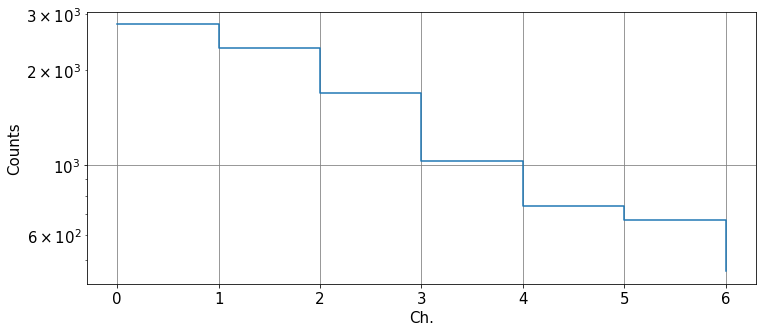

In [253]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)

#yy = yy.loc['2021-08-15 11:00:00':'2021-08-16 18:00:00']
#yy = yy.loc['2021-8-3 16:45:00':'2021-8-3 16:48:00']
#yy = yy.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
#yy = yy.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
#yy = yy.loc['2021-07-08 17:00:00':'2021-07-08 18:00:00']

#yy = yy.loc['2021-05-12 11:20:00':'2021-05-12 11:30:00']
#yy = yy.loc['2021-05-12 13:58:00':'2021-05-12 14:20:00']

yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:258],range(0,258))})
ener = yy.iloc[:,11:18].sum()
ener = ener.reset_index()
plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-post')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([0,30])

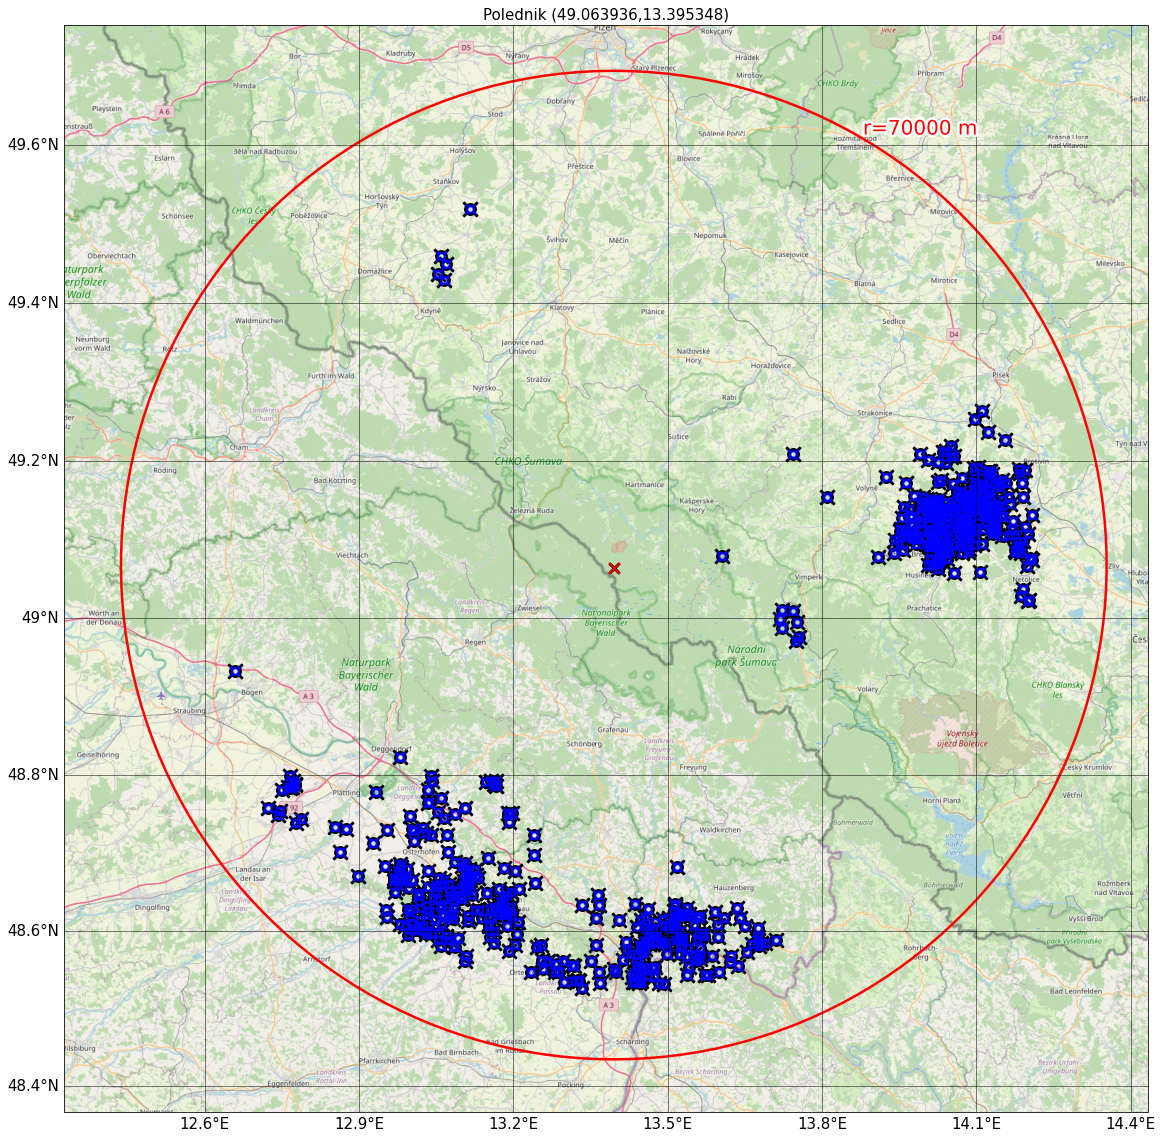

In [263]:
__title__   = 'Plot OpenStreetMap site map'
__version__ = 'v1.0 (2021-03-02)'
__author__  = 'Mathew Lipson'
__email__   = 'm.lipson@unsw.edu.au'

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import cartopy
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

projpath = '.'

##########################################################################

def main():

    sitename = 'Polednik'
    lat = 49.063936
    lon = 13.395348
    #lat = 49.5
    #lon = 14.3

    # style can be 'map' or 'satellite'

    #for style in ['map','satellite']:

    osm_image(lon, lat, sitename=sitename, style='map', radius=70000, npoints=0)

    return

##########################################################################

def osm_image(lon,lat,sitename='Columbo',style='satellite',radius=500,npoints=500):
    '''This function makes OpenStreetMap satellite or map image with circle and random points.
    Change np.random.seed() number to produce different (reproducable) random patterns of points.
    Also review 'scale' variable'''

    if style=='map':
        ## MAP STYLE
        cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.OSM() # spoofed, downloaded street map
    elif style =='satellite':
        # SATELLITE STYLE
        cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
    else:
        print('no valid style')

    stroke = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

    ############################################################################

    plt.close('all')
    fig = plt.figure(figsize=(20,20)) # open matplotlib figure
    ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
    data_crs = ccrs.PlateCarree()

    ax.set_title(f'{sitename} ({lat},{lon})',fontsize=15)

    # auto-calculate scale
    scale = int(120/np.log(radius))
    scale = (scale<20) and scale or 19

    # or change scale manually
    # NOTE: scale specifications should be selected based on radius
    # but be careful not have both large scale (>16) and large radius (>1000), 
    #  it is forbidden under [OSM policies](https://operations.osmfoundation.org/policies/tiles/)
    # -- 2     = coarse image, select for worldwide or continental scales
    # -- 4-6   = medium coarseness, select for countries and larger states
    # -- 6-10  = medium fineness, select for smaller states, regions, and cities
    # -- 10-12 = fine image, select for city boundaries and zip codes
    # -- 14+   = extremely fine image, select for roads, blocks, buildings

    extent = calc_extent(lon,lat,radius*1.1)
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(scale)) # add OSM with zoom specification

    # add site
    ax.plot(lon,lat, color='black', marker='x', ms=10, mew=3, transform=data_crs)
    ax.plot(lon,lat, color='red', marker='x', ms=11, mew=2, transform=data_crs)

    if npoints>0: 
        # set random azimuth angles (seed for reproducablity)
        np.random.seed(1235)
        rand_azimuths_deg = np.random.random(npoints)*360

        # set random distances (seed for reproducablity)
        np.random.seed(6341)
        rand_distances = radius*np.sqrt((np.random.random(npoints))) # np.random.uniform(low=0, high=radius, size=npoints)

        rand_lon = cgeo.Geodesic().direct((lon,lat),rand_azimuths_deg,rand_distances)[:,0]
        rand_lat = cgeo.Geodesic().direct((lon,lat),rand_azimuths_deg,rand_distances)[:,1]

        ax.plot(rand_lon,rand_lat,color='black',lw=0,marker='x',ms=4.5,mew=1.0,transform=data_crs)
        ax.plot(rand_lon,rand_lat,color='yellow',lw=0,marker='x',ms=4,mew=0.5,transform=data_crs)

    lightning = blitz.loc['2021-08-15 16:00:00':'2021-08-15 20:00:00']
    ax.plot(lightning.lon,lightning.lat,color='black',lw=0,marker='$🗲$',ms=15,mew=1.0,transform=data_crs)
    ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$🗲$',ms=10,mew=1.0,transform=data_crs)
    #ax.plot(lightning.lon,lightning.lat,color='black',lw=0,marker='x',ms=4.5,mew=1.0,transform=data_crs)
    #ax.plot(lightning.lon,lightning.lat,color='yellow',lw=0,marker='x',ms=4,mew=0.5,transform=data_crs)

    # add cartopy geodesic circle
    circle_points = cgeo.Geodesic().circle(lon=lon, lat=lat, radius=radius)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none', linewidth=2.5)

    radius_text = cgeo.Geodesic().direct(points=(lon,lat),azimuths=30,distances=radius)[:,0:2][0]
    stroke = [pe.Stroke(linewidth=5, foreground='w'), pe.Normal()]
    ax.text(radius_text[0],radius_text[1],f'r={radius} m', color='red', 
        fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)

    gl = ax.gridlines(draw_labels=True, crs=data_crs,
                        color='k',lw=0.5)

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

    plt.show()

    #fig.savefig(f'{projpath}/{sitename}_{style}_r{radius}_pts{npoints}_scale{scale}.jpg', dpi=150, bbox_inches='tight')

    return

def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1], top_left[1]]

    return extent

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

if __name__ == "__main__":

   main()